In [1]:
from edge_sensor.radio import airt
import labbench as lb

lb.show_messages('info')
sdr = airt.AirT7201B()

In [2]:
sdr.open()

 INFO   2024-07-05 11:36:27,648.648 • AirT7201B(): connecting


 INFO   2024-07-05 11:36:33,565.566 • AirT7201B(): connected


In [3]:
from edge_sensor import structs
from channel_analysis import waveform
import xarray as xr
import importlib

structs = importlib.reload(structs)

run_spec, sweep_fields = structs.read_yaml_sweep('run.yaml')

data = []

lb.show_messages('info')

try:
    for capture in run_spec.captures:
        coords = {f: [getattr(capture, f)] for f in sweep_fields}
        print(coords)
        sdr.arm(capture)
        iq = sdr.acquire()
        analysis = waveform.analyze_by_spec(
            iq, capture, spec=run_spec.channel_analysis
        ).assign_coords(coords)
        for f in sweep_fields:
            del analysis.attrs[f]
        data.append(analysis)
finally:
    pass
    # sdr.channel_enabled(False, channel=0)

data = xr.combine_by_coords(data)

{'center_frequency': [3710000000.0], 'gain': [0.0]}
{'center_frequency': [3730000000.0], 'gain': [0.0]}
{'center_frequency': [3750000000.0], 'gain': [0.0]}
{'center_frequency': [3770000000.0], 'gain': [0.0]}
{'center_frequency': [3790000000.0], 'gain': [0.0]}
{'center_frequency': [3810000000.0], 'gain': [0.0]}


In [4]:
data

<xarray.Dataset> Size: 86MB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         center_frequency: 6,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         iq_index: 1536000, gain: 1)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * iq_index                            (iq_index) int64 12MB 0 1 ... 1535999
  * center_frequency                    (center_frequency) float64 48B 3.71e+...
  * gain                                (gain) float64 8B 0.0
Data variables:
    power_time_series                   (center_frequency, power_detector, time_elapsed) float32 480B ...
    cyclic_channel_power                (center_frequency, power_detector, cyclic_statistic, cyclic_lag) float32 86kB ...
    amplitude_probability_distribution  (center_frequency, channel_power) float32 5kB ...
    persistence_spectrum                (center_frequency, persistence_statistic, baseband_frequency) float32 144kB ...
    iq_waveform                         (center_frequency, iq_index) complex64 74MB ...
Attributes:
    duration:            0.1
    sample_rate:         15360000.0
    channel:             0
    analysis_bandwidth:  10000000.0
    lo_shift:            left
    if_frequency:        None
    lo_gain:             0
    rf_gain:             0

In [5]:
# import importlib

# from channel_analysis import config
# config = importlib.reload(config)

# from channel_analysis import waveform
# waveform = importlib.reload(waveform)
# waveform.config = config

# analysis_spec = {
#     'power_time_series': {
#         'detector_period': 10e-3,
#         'detectors': ('rms', 'peak')
#     },
#     'cyclic_channel_power': {
#         'cyclic_period': 10e-3,
#         'detector_period': 1e-3 / 15 / 4,
#         'detectors': ('rms', 'peak'),
#         'cyclic_statistics': ('min', 'mean', 'max'),
#     },
#     'persistence_spectrum': {
#         'window': 'flattop',
#         'resolution': 15e3,
#         'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
#         'truncate': True
#     },
#     'amplitude_probability_distribution': {
#         'power_low': -105,
#         'power_high': -60,
#         'power_count': 221,  # 0.25 dB resolution
#     },
#     # 'iq_waveform': {
#     #     'start_time_sec': 0,
#     #     'stop_time_sec': 100e-3
#     # }
# }

# filter_spec = {}

# data = waveform.from_spec(
#     iq,
#     sdr,
#     analysis_spec=analysis_spec,
# )

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


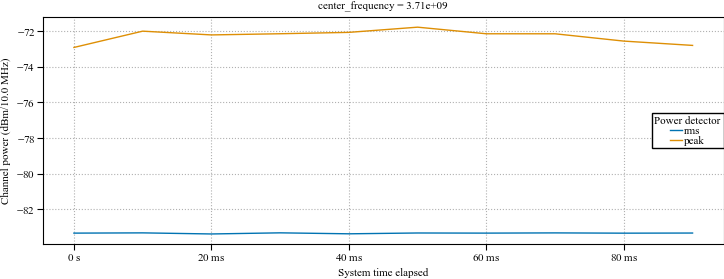

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

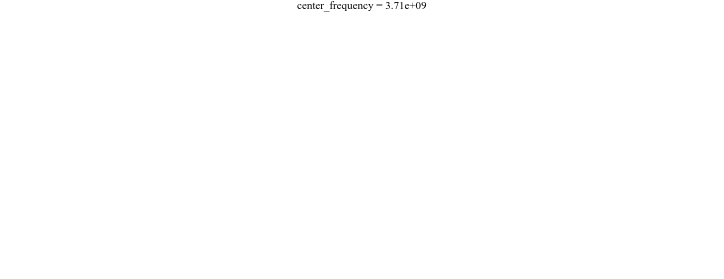

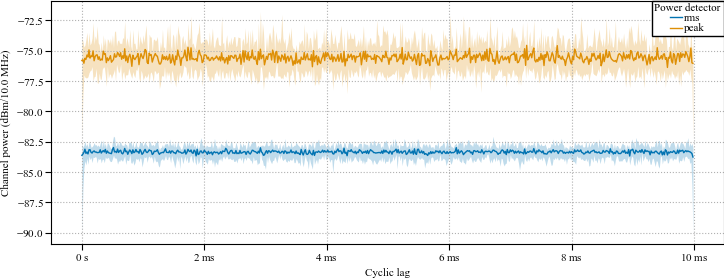

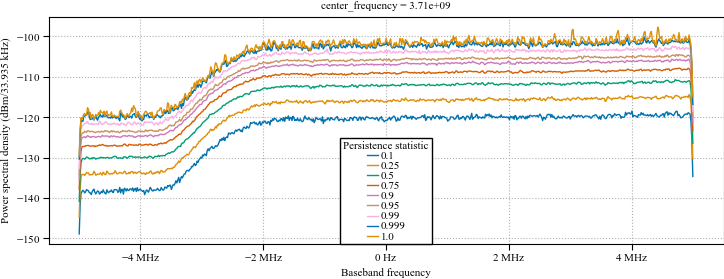

In [9]:
import iqwaveform
from channel_analysis import figures
import matplotlib.pyplot as plt
from iqwaveform import powtodB

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
pvt = data.power_time_series.sel(center_frequency=3710e6)
pvt.plot.line(x='time_elapsed', ax=ax)
figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

fig, ax = plt.subplots()
apd = data.amplitude_probability_distribution.sel(center_frequency=3710e6)
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

fig, ax = plt.subplots()
cyclic_power = data.cyclic_channel_power.sel(center_frequency=3710e6)
time = cyclic_power.cyclic_lag
for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

fig, ax = plt.subplots()
spectrum = data.persistence_spectrum.sel(center_frequency=3710e6)
spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')